# Notebook to look at relationship between steering muscle spike rate and stroke amplitude

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [196]:
import os
import glob
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, medfilt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.stats import zscore

from mosquito.process_abf import load_processed_data, estimate_spike_rate, save_processed_data
from mosquito.util import idx_by_thresh, my_adjust_axes, hampel, set_plot_params, my_add_scalebar
from mosquito.read_photron import my_read_cih

## Params

In [176]:
# plt.style.use('dark_background')
plt.style.use('default')

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels

plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)

In [4]:
# hampel filter params
hampel_k = 101  # 201  # 21
hampel_t0 = 0.01

## Helper functions

In [118]:
def plot_correlogram(data, group_idx=None, cmap_name='Set3', data_labels=None, fig=None, marker_size=3, 
                     alpha=0.5, nbins=10, lower_flag=True):
    """
    Function to make a NxN matrix of plots (or just upper triangular region) 
    comparing a set of N measurements against each other

    Args:
        data: NxM numpy array containing data, where N corresponds to number of data variables, 
            and M is the number of measurements per variable
        group_idx: Mx1 numpy array containing numerical labels for data points, if grouping
        cmap_name: string giving a colormap name that will be used for coloring different groups
        data_labels: list of N strings giving labels for data rows.
        fig: matplotlib figure to add plots to
        marker_size: size of markers for scatter plots
        alpha: transparency value for plotted data
        nbins: integer. number of bins to use for diagonal histograms
        lower_flag: boolean. if true, only plot to lower triangle of axes matrix. 
            otherwise do full NxN
        
    Returns:
        fig: matplotlib figure object
        axes: matplotlib axes

    TODO:
        - axis labels
    """
    # initialize figure if we don't have it
    if fig is None:
        fig = plt.figure()

    # get dimensions of data
    n_vars = data.shape[0]

    # initialize subplot axes
    axes = fig.subplots(nrows=n_vars, ncols=n_vars)
    
    # # Hide all ticks and labels to start
    # for ax in axes.flat:
    #     ax.xaxis.set_visible(False)
    #     ax.yaxis.set_visible(False)
        
    # make a dummy group index, if none is provided
    if group_idx is None:
        group_idx = np.ones_like(data[0,:])
        
    group_idx_unique = np.unique(group_idx)

    # make a list of colors for each group we might run into
    cmap = plt.colormaps[cmap_name]
    cmap_vals = cmap(np.linspace(0, 1, cmap.N))
    colors = list()
    
    for ith in range(group_idx_unique.size):
        colors.append(cmap_vals[ith % cmap.N])

    # make a dummy list of data labels if none is provided
    if data_labels is None:
        data_labels = ['' for kth in range(n_vars)]
        
    # loop over matrix positions
    for row in range(n_vars):
        for col in range(n_vars):
            # check to see that we're in upper triangle, if using
            if (col > row) and lower_flag:
                axes[row][col].set_axis_off()
                continue

            # loop over groups
            for jth, gidx in enumerate(group_idx_unique):
                # get index for current group 
                idx = (group_idx == gidx)
                
                # make plots. switch case depending on whether this is on diagonal (histogram) 
                # or off (scatterplot)
                if row == col:
                    # histogram
                    axes[row][col].hist(data[row][idx], bins=nbins,
                                        density=True, color=colors[jth],
                                       alpha=alpha)

                if row != col:
                    # scatter
                    axes[row][col].plot(data[col][idx], data[row][idx], 
                                        'o', color=colors[jth], 
                                        markersize=marker_size, 
                                       alpha=alpha)

                # turn axis lines/ticks to visible again if we want them
                yaxis_vis = False
                xaxis_vis = False
                if (row == col) and lower_flag:                    
                    # axes[row][col].yaxis.set_visible(True)
                    yaxis_vis = True
                    axes[row][col].set_ylabel('pdf')
                    
                if (row == (n_vars-1)):
                    # axes[row][col].xaxis.set_visible(True)
                    xaxis_vis = True
                    label_curr = data_labels[col].replace('_', ' ')
                    if label_curr == 'left amp':
                        label_curr += ' (rad)'
                    elif label_curr in ['wbf', 'spike rate']:
                        label_curr += ' (Hz)'
                    axes[row][col].set_xlabel(label_curr)
                    
                if (col == 0) and (row != col) and lower_flag:
                    # axes[row][col].yaxis.set_visible(True)
                    yaxis_vis = True
                    label_curr = data_labels[row].replace('_', ' ')
                    if label_curr == 'left amp':
                        label_curr += ' (rad)'
                    elif label_curr in ['wbf', 'spike rate']:
                        label_curr += ' (Hz)'
                    axes[row][col].set_ylabel(label_curr)

                keep_spines = []
                if yaxis_vis:
                    keep_spines.append('left')
                if xaxis_vis:
                    keep_spines.append('bottom')

                axes[row][col] = my_adjust_axes(axes[row][col], keep_spines=keep_spines, trim_ticks_flag=False)
                
                # set axis labels - TODO
                # if (data_labels is not None) and :
                

    # return matplotlib objects
    return fig, axes
    

In [6]:
# # test
# data_in = np.random.rand(3, 200)
# plot_correlogram(data_in, upper_flag=True)

## Load data

In [10]:
# example data trial to start with
data_folder = 50 # 50
axo_num = 27 # 27  # 28

try:
    data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
except ValueError:
    data = load_processed_data(data_folder, axo_num, data_suffix='_processed')


In [13]:
# read out data variables
t = data['time']
right_amp = data['wing']['right_amp_raw']
left_amp = data['wing']['left_amp_raw']
wbf = data['wbf']
fs = data['sampling_freq']
flying_idx = data['flying_idx'] 


In [14]:
print(data['wing'].keys())

dict_keys(['left_amp_raw', 'left_amp', 'right_amp_raw', 'right_amp', 'record_fps', 'vid_filepath'])


(5.01, 5.02)

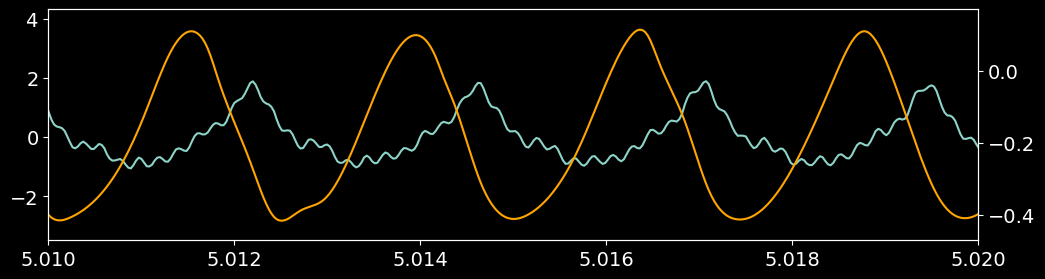

In [22]:
mic = data['mic']

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(t, mic)

axtwin = ax.twinx()
axtwin.plot(t,  data['wing']['right_lead'],color='orange')
ax.set_xlim([5.01, 5.02])

In [60]:
# need to get updated spike rate
if 'good_spike_idx' in data.keys():
    spike_idx = data['good_spike_idx']
else:
    spike_idx = data['spike_idx']

spike_rate = estimate_spike_rate(spike_idx, fs, t.size, win_factor=2*8)


## Filter wing kinematics

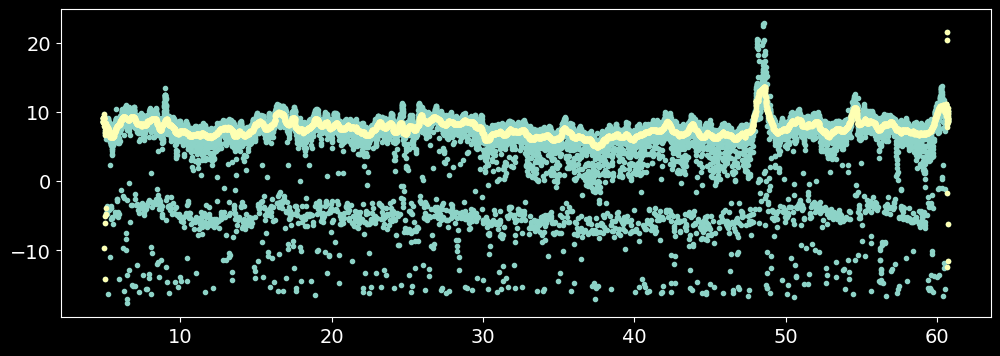

In [61]:
# run hampel filter
signal_raw = left_amp
signal_filt = signal_raw.copy()
nan_idx = np.isnan(signal_filt)
# nan_idx |= (signal_filt < -np.pi/4)

signal_filt[~nan_idx], outlier_idx = hampel(signal_filt[~nan_idx], k=hampel_k, t0=0.01)  # k=21
outlier_idx = np.where(~nan_idx)[0][outlier_idx]

# try to interpolate
signal_interp = np.interp(t, t[~nan_idx], signal_filt[~nan_idx])

# visualize 
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, np.rad2deg(signal_raw), '.')
ax.plot(t, np.rad2deg(signal_filt), '.')
# ax.set_xlim([10, 20])

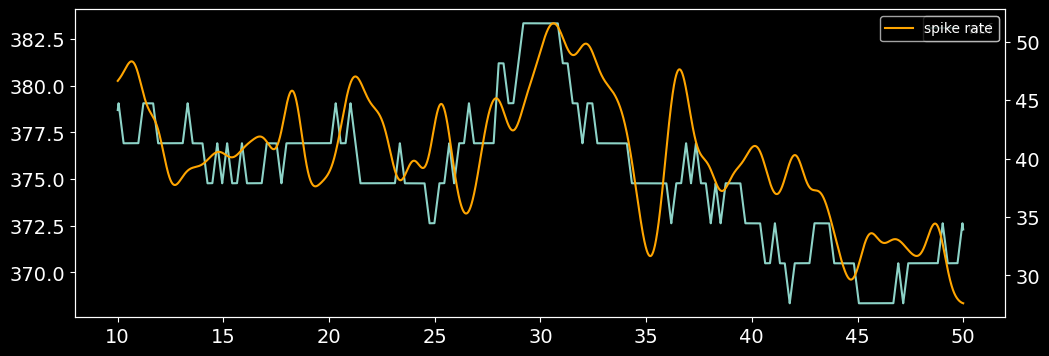

In [149]:
# look at stroke amp and other variables
fig, ax = plt.subplots(figsize=(12,4))

# mask to only look at some of plot
tmin = 10
tmax = 50 # 7 # 5.11
mask = (t >= tmin) & (t <= tmax)

# plot
# ax.plot(t[mask], np.rad2deg(signal_interp[mask]), '-', label='amp')
ax.plot(t[mask], wbf[mask], '-', label='wbf')

ax_twin = ax.twinx()
ax_twin.plot(t[mask], spike_rate[mask], color='orange', label='spike rate')
# ax_twin.plot(t[mask], wbf[mask], color='orange', label='wbf')
ax.legend()
ax_twin.legend()

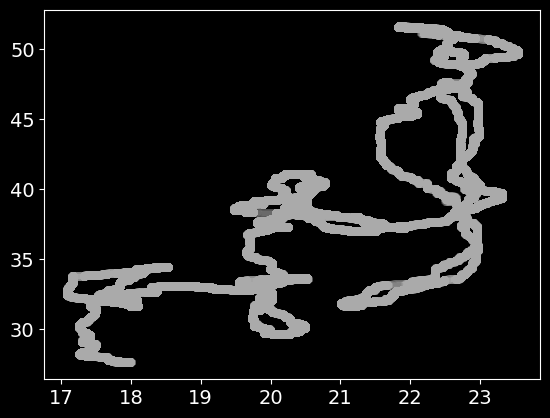

In [12]:
# test plotting vs each other
plt.plot(np.rad2deg(signal_interp[mask]), spike_rate[mask], 'wo', alpha=0.01)

## Same issues as with power muscle spike rate vs wbf -- need to bin(?)

In [13]:
# define bin edges
bin_width = 262144/8  #  262144/4
bin_edges = np.arange(0, wbf.size, bin_width)
bin_idx = np.digitize(np.arange(wbf.size), bin_edges)


In [14]:
# collect data in bins (use pandas)
# # this try statement is used for cross-correlation alignment
# try:
#     spike_rate_in = np.roll(spike_rate, lags[np.argmax(corr)])
#     spike_rate_in = spike_rate_in[flying_idx]
# except:
#     spike_rate_in = spike_rate[flying_idx]
vid_start_idx = np.where(~np.isnan(left_amp))[0][0]
vid_end_idx = np.where(~np.isnan(left_amp))[0][-1]
tmp = np.arange(left_amp.size)
vid_idx = (tmp >= vid_start_idx) & (tmp <= vid_end_idx)

data_idx = flying_idx & vid_idx

d = {'time': t[data_idx], 
     'wbf': wbf[data_idx], 
     'spike_rate': spike_rate[data_idx], 
     'left_amp': signal_interp[data_idx],
     'bin_idx': bin_idx[data_idx]}
df = pd.DataFrame(data=d)

df_binned = df.groupby(['bin_idx']).mean()
# df_binned

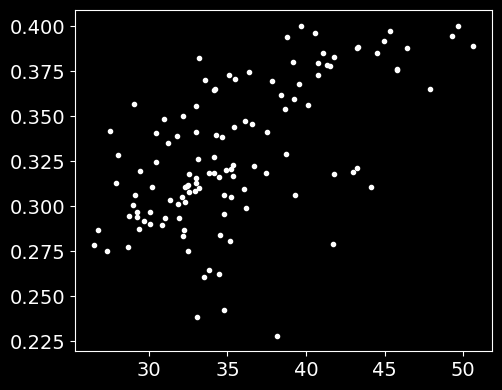

In [15]:
# plot binned results
fig, ax = plt.subplots(figsize=(2*2.5,2*2))

ax.plot(df_binned['spike_rate'][1:-1], df_binned['left_amp'][1:-1], 'w.') # , 'w.', ms=1, alpha=0.4)
#ax.plot(df_binned['spike_rate'][1:-1], m*df_binned['spike_rate'][1:-1] + b, 'r-', lw=0.75)

# ax.set_xlabel('burst rate (Hz)')
# ax.set_ylabel('wingbeat freq. (Hz)')

fig.tight_layout()


In [16]:
df_binned[['wbf', 'left_amp', 'spike_rate']][1:-1].corr()

,wbf,left_amp,spike_rate
wbf,1.000000,0.025169,0.317984
left_amp,0.025169,1.000000,0.607033
spike_rate,0.317984,0.607033,1.000000


(array([0.0281, 0.0632, 0.0878, ..., 0.0211, 0.007 , 0.0105]),
 array([26.5268, 28.9402, 31.3535, ..., 45.8334, 48.2467, 50.66  ]),
 <BarContainer object of 10 artists>)

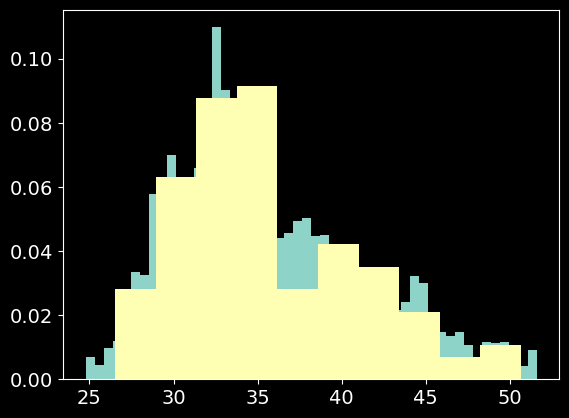

In [20]:
plt.hist(spike_rate[vid_idx],bins=50, density=True)
plt.hist(df_binned['spike_rate'][1:-1], density=True)


## Loop over several data files to aggregate spike and stroke amp data

In [187]:
# which files to look at?
# data_ids = [[50, 3], [50, 9], [50, 15], [50, 21], [50, 22],  [50, 27], [50, 28], [48,0], [55, 7], [55, 8], [56, 5], [57, 3]]
data_ids = [[50, 3], [50, 9], [50, 21], [50, 22],  [50, 27], [50, 28], [48,0], [55, 7], [55, 8]]

# what should the bin size be?
bin_width = 262144/8  #  262144/4

# should we zscore?
zscore_flag = True


In [188]:
# loop over data files, load, process, add to larger dataframe(?)
for ith, data_id in enumerate(data_ids):
    # parse data_id
    data_folder = data_id[0]
    axo_num = data_id[1]

    print(f'fetching data from expr {data_folder}, axo {axo_num}...')
    
    # -------------------------------------------
    # load data 
    try:
        data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
    except ValueError:
        data = load_processed_data(data_folder, axo_num, data_suffix='_processed')

    # -------------------------------------------
    # read data variables
    t = data['time']
    left_amp = data['wing']['left_amp_raw']  #  data['wing']['left_lead_raw']
    wbf = data['wbf']
    flying_idx = data['flying_idx'] 
    fs = data['sampling_freq']

    # -------------------------------------------
    # get updated spike rate
    if 'good_spike_idx' in data.keys():
        spike_idx = data['good_spike_idx']
    else:
        spike_idx = data['spike_idx']

    if type(spike_idx) is list:
        # HACKY - for now just taking first channel of multichannel recordings
        spike_idx = spike_idx[1]
        
    spike_rate = estimate_spike_rate(spike_idx, fs, t.size, win_factor=2*8)

    # -------------------------------------------
    # filter wing kinematics
    signal_raw = left_amp
    signal_filt = signal_raw.copy()
    nan_idx = np.isnan(signal_filt)
    # nan_idx |= (signal_filt < -np.pi/4)
    
    signal_filt[~nan_idx], outlier_idx = hampel(signal_filt[~nan_idx], k=hampel_k, t0=hampel_t0)  # k=21
    outlier_idx = np.where(~nan_idx)[0][outlier_idx]
    
    # try to interpolate
    signal_interp = np.interp(t, t[~nan_idx], signal_filt[~nan_idx])

    # -------------------------------------------
    # bin data
    bin_edges = np.arange(0, wbf.size, bin_width)
    bin_idx = np.digitize(np.arange(wbf.size), bin_edges)

    # restrict attention to region of data when video is recording
    vid_start_idx = np.where(~np.isnan(left_amp))[0][0]
    vid_end_idx = np.where(~np.isnan(left_amp))[0][-1]
    tmp = np.arange(left_amp.size)
    vid_idx = (tmp >= vid_start_idx) & (tmp <= vid_end_idx)

    data_idx = flying_idx & vid_idx

    # make a data dictionary
    if zscore_flag:
        d = {'time': t[data_idx], 
             'wbf': zscore(wbf[data_idx]), 
             'spike_rate': zscore(spike_rate[data_idx]), 
             'left_amp': zscore(signal_interp[data_idx]),
             'bin_idx': bin_idx[data_idx],
             'group_idx': ith*np.ones_like(bin_idx[data_idx])}

    else:
        d = {'time': t[data_idx], 
             'wbf': wbf[data_idx], 
             'spike_rate': spike_rate[data_idx], 
             'left_amp': signal_interp[data_idx],
             'bin_idx': bin_idx[data_idx],
             'group_idx': ith*np.ones_like(bin_idx[data_idx])}

    # convert to dataframe and bin
    df = pd.DataFrame(data=d)
    df_binned = df.groupby(['bin_idx']).mean()

    # store in aggregate structure
    if ith == 0:
        df_binned_all = df_binned.copy()
    else:
        df_binned_all = pd.concat([df_binned_all, df_binned], ignore_index=True)
        
    print(f'completed fetching data from expr {data_folder}, axo {axo_num}')

print('Done!')

fetching data from expr 50, axo 3...
completed fetching data from expr 50, axo 3
fetching data from expr 50, axo 9...
completed fetching data from expr 50, axo 9
fetching data from expr 50, axo 21...
completed fetching data from expr 50, axo 21
fetching data from expr 50, axo 22...
completed fetching data from expr 50, axo 22
fetching data from expr 50, axo 27...
completed fetching data from expr 50, axo 27
fetching data from expr 50, axo 28...
completed fetching data from expr 50, axo 28
fetching data from expr 48, axo 0...
completed fetching data from expr 48, axo 0
fetching data from expr 55, axo 7...
completed fetching data from expr 55, axo 7
fetching data from expr 55, axo 8...
completed fetching data from expr 55, axo 8
Done!


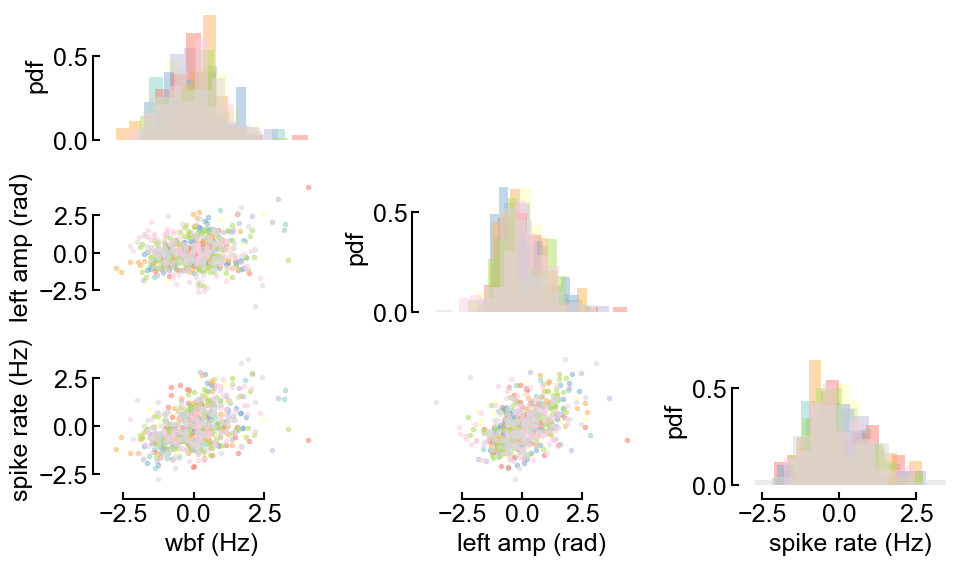

In [190]:
# make plot
data_labels = ['wbf', 'left_amp', 'spike_rate']
data_mat = np.transpose(df_binned_all[data_labels].values)
group_idx = df_binned_all['group_idx'].values.astype('int')

fig = plt.figure(figsize=(10,6))

fig, axes = plot_correlogram(data_mat, group_idx=group_idx, fig=fig, data_labels=data_labels, alpha=1.0 - 0.5*zscore_flag)
fig.tight_layout()

if zscore_flag:
    save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/dfm_recordings/b1_corr_zscored.png'
else:
    save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/dfm_recordings/b1_corr.png'

fig.savefig(save_path) 

In [191]:
test = np.array([1,2,3,4,5])
test[[0, -1]]


array([1, 5])

In [192]:
# get correlation coefficients
df_binned_all[data_labels].corr()

,wbf,left_amp,spike_rate
wbf,1.00000,0.185180,0.382440
left_amp,0.18518,1.000000,0.403668
spike_rate,0.38244,0.403668,1.000000


In [34]:
temp = df_binned_all.groupby([group_idx]).var()
temp

,time,wbf,spike_rate,left_amp,group_idx
0,274.380478,26.990438,33.793530,0.000340,0.0
1,274.380359,11.424624,41.481270,0.000719,0.0
2,274.380244,53.416259,37.061229,0.002788,0.0
3,274.379674,18.975911,19.698769,0.000966,0.0
4,274.380193,104.103405,44.141228,0.004656,0.0
5,274.379744,61.590787,33.526291,0.005734,0.0
6,1055.205574,13.558262,29.164893,0.001786,0.0
7,1072.360037,5.493798,55.780090,0.000415,0.0
8,1072.359854,4.308512,7.958761,0.000191,0.0
9,1072.359868,219.143035,166.323269,0.005615,0.0


In [42]:
# Get mic phase at wingbeat for the same flies
b1_phase = []

for ith, data_id in enumerate(data_ids):
    # parse data_id
    data_folder = data_id[0]
    axo_num = data_id[1]

    print(f'fetching data from expr {data_folder}, axo {axo_num}...')
    
    # -------------------------------------------
    # load data 
    try:
        data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
    except ValueError:
        data = load_processed_data(data_folder, axo_num, data_suffix='_processed')

    # get phase of mic signal
    mic_phase = data['mic_phase']

    # get index of spikes
    if 'good_spike_idx' in data.keys():
        spike_idx = data['good_spike_idx']
    else:
        spike_idx = data['spike_idx']

    if type(spike_idx) is list:
        # HACKY - for now just taking first channel of multichannel recordings
        spike_idx = spike_idx[1]

    # store b1 firing phase in list
    b1_phase.append(mic_phase[spike_idx])

print('Done!')

fetching data from expr 50, axo 3...
fetching data from expr 50, axo 9...
fetching data from expr 50, axo 21...
fetching data from expr 50, axo 22...
fetching data from expr 50, axo 27...
fetching data from expr 50, axo 28...
fetching data from expr 48, axo 0...
fetching data from expr 55, axo 7...
fetching data from expr 55, axo 8...
fetching data from expr 57, axo 3...
Done!


<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_169653/3982195525.py:25: SyntaxWarning: invalid escape sequence '\p'
  ax_list[ith].set_xticklabels(['-$\pi$', '$\pi$'])
/tmp/ipykernel_169653/3982195525.py:25: SyntaxWarning: invalid escape sequence '\p'
  ax_list[ith].set_xticklabels(['-$\pi$', '$\pi$'])


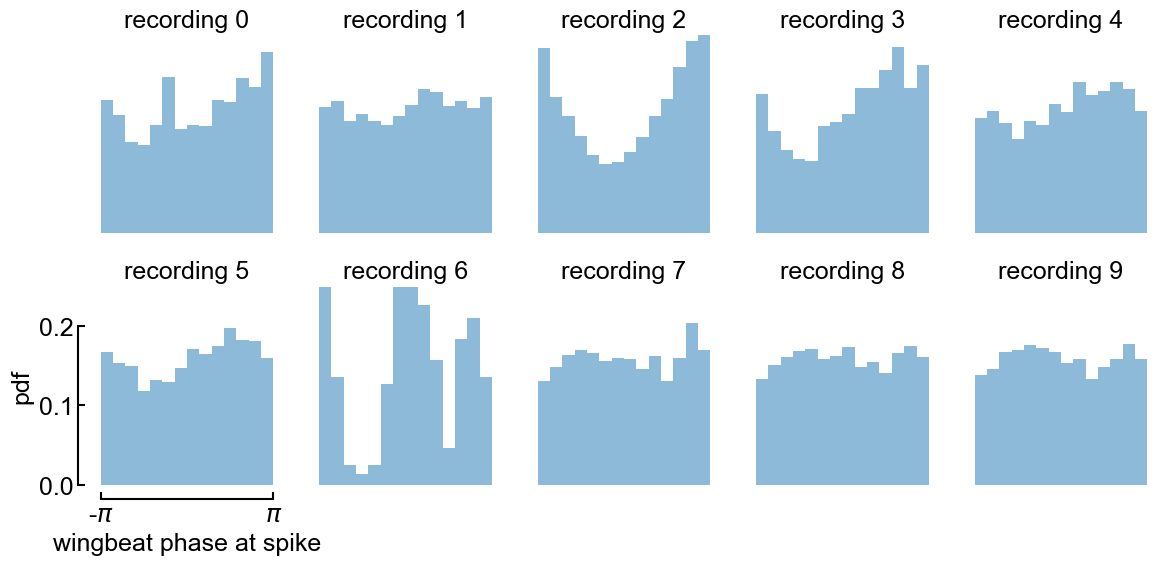

In [204]:
# make figure
fig, ax_list = plt.subplots(round(len(b1_phase)/5), 5, figsize=(12, 6))
ax_list = ax_list.ravel()

phases_binned = []
edges = np.linspace(-np.pi, np.pi, 15)
ctrs = (edges[1:] + edges[:-1])/2.0
spacing = 0.1

# do KDE
# kde = KernelDensity(kernel="gaussian", bandwidth=0.35).fit(mic_phase_at_spike.reshape(-1, 1))
# log_dens = kde.score_samples(phase_range.reshape(-1, 1))
# ax.plot(phase_range, np.exp(log_dens), color=mosquito_female_color, lw=1.5)
for ith, phases in enumerate(b1_phase):
    n, _, _ = ax_list[ith].hist(phases, bins=edges, density=True, lw=1.5, alpha=0.5)  # histtype='step', 
    # n, _ = np.histogram(phases, bins=edges, density= True)
    # ax.stairs(n+(ith*spacing - n[0]), edges=edges, baseline=None)
    # phases_binned.append(n)
    
    ax_list[ith].set_ylim([0, 0.25])
    ax_list[ith].set_title(f'recording {ith}')
    
    if ith == (len(b1_phase) - 5):
        ax_list[ith].set_xticks([-np.pi, np.pi])
        ax_list[ith].set_xticklabels(['-$\pi$', '$\pi$'])
        ax_list[ith].set_xlabel('wingbeat phase at spike')
        ax_list[ith].set_ylabel('pdf')
        ax_list[ith] = my_adjust_axes(ax_list[ith], keep_spines=['left', 'bottom'])
    else:
        ax_list[ith] = my_adjust_axes(ax_list[ith], keep_spines=['none'])
        
# ax.stairs(np.mean(np.vstack(phases_binned), axis=0), edges=edges, color='w', lw=4)

# adjust axes
# ax.set_ylabel('fly')
# ax.set_xlabel('wingbeat phase at spike')

# ax.set_xticks([-np.pi, np.pi])
# ax.set_xticklabels(['-$\pi$', '$\pi$'])
# ax = my_adjust_axes(ax, keep_spines=['bottom'])
fig.tight_layout()

save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/dfm_recordings/b1_phase.png'
fig.savefig(save_path)

In [149]:
len(phases)

6802

In [57]:
phases_binned[0].size

14

In [201]:
# TEMP plot multichannel
# example data trial to start with
data_folder = 57 # 50
axo_num = 3 # 27  # 28

try:
    data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
except ValueError:
    data = load_processed_data(data_folder, axo_num, data_suffix='_processed')


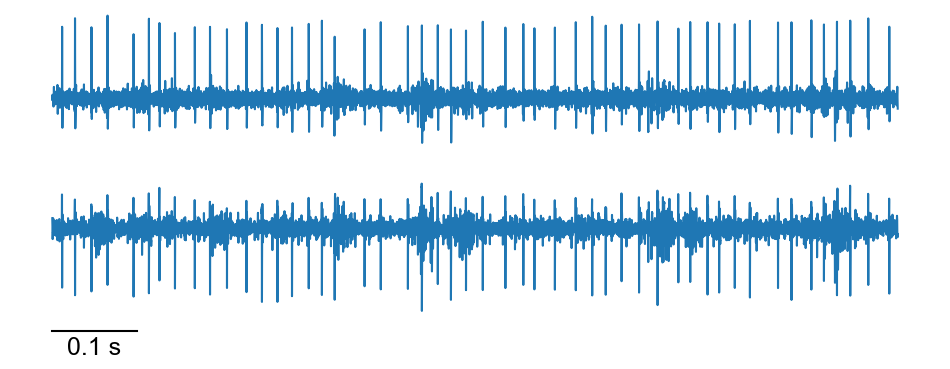

In [203]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,4), sharex=True)
t = data['time']

# mask to only look at some of plot
tmin = 10
tmax = 11 # 7 # 5.11
mask = (t >= tmin) & (t <= tmax)

# plot
# ax.plot(t[mask], np.rad2deg(signal_interp[mask]), '-', label='amp')
ax0.plot(t[mask] - t[mask][0], data['emg_filt'][0][mask], '-')
ax1.plot(t[mask] - t[mask][0], data['emg_filt'][1][mask], '-')

ax0 = my_adjust_axes(ax0, keep_spines=['none'])
ax1 = my_adjust_axes(ax1, keep_spines=['bottom'])
my_add_scalebar(ax1, [0, 0.1], linewidth=1.5, units='s')

save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/dfm_recordings/multi_channel_test.png'
fig.savefig(save_path)